# Neural Networks for Count Data 

Redo the Poisson Regression for the fish data set, now with keras. From the previous exercise:

## Fish Data Set

The following data-set contains the number of Fish a group of camper caught in a state park (taken from https://stats.idre.ucla.edu/r/dae/zip/). Your task here is to predict the number of fish $y$ caught by a fishing party. We have a small data set, of 250 groups, which visited a state park and provided the following information: 

* how many people are in the group
* the number children in the group
* the use of live bait
* whether the group came with a camper to the park. 

Split the data set into a training set and testset. Use the first 200 entries for training, the remaining 50 for testing. See below for code how to read the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
%matplotlib inline

In [2]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
# np.savez('fishing.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
#https://github.com/ioskn/mldl_htwg/raw/master/data/fishing.npz
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')
X_train = d['Xt'] #"livebait","camper","persons","child"
X_test = d['Xte']
y_train = d['yt']
y_test = d['yte']
pd.DataFrame(X_train[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


## Results from the Machine Learning excercise, we had. 

### LinearRegression

In [3]:
from sklearn.linear_model import LinearRegression
Xd = np.hstack([np.ones((X_train.shape[0],1)), X_train])
pd.DataFrame(Xd[0:2])
Xdt = np.hstack([np.ones((X_test.shape[0],1)), X_test])
X_train.shape,Xd.shape
model_skl = LinearRegression(fit_intercept=False)
res = model_skl.fit(Xd, y_train)
res.coef_

array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])

#### RMSE and NLL
Determine the Root Mean Square Error (RMSE) and the average negative log-likelihood (NLL) on the testset. For NLL we assume that the conditional probability distrubution (CPD) $p(y|x)$ is given by the density of a Gaussian with constant variance $\sigma^2$. Estimate $\sigma^2$ using the variance of the residuals. Use the variance estimation with $1/N$. 


In [4]:
ypred = model_skl.predict(Xdt)
#ypred = np.ones_like(y_test) * np.median(y_train)
sigma_hat_2 = np.mean((y_test - ypred.flatten())**2)
np.sqrt(sigma_hat_2),sigma_hat_2,Xdt.shape

(8.588126386734231, 73.75591483452077, (50, 5))

In [5]:
0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - ypred.flatten())**2)/sigma_hat_2

3.5693191297796893

#### Comparison with test set

For the testset: plot the mean of the predicted number of fish caught against observed number of fish caught. Further include the 2.5 and 97.25 precentile of p(y|x), the conditional predictive distribution (CPD) of $y$ for a given $x$. Why is a Gaussian not ideal for that kind of data? For the Gaussian the 2.5% and the 97.5% percentile is approximatiy given by $\mu \pm 1.96*\sigma$

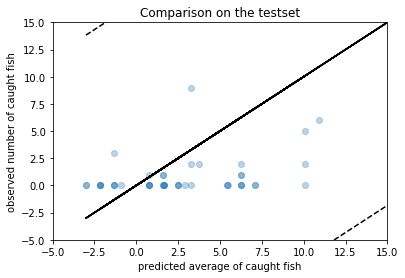

In [6]:
plt.scatter(ypred, y_test,alpha=0.3)
sort_idx=np.argsort(ypred,axis=0)
plt.plot(ypred[sort_idx].flatten(), ypred[sort_idx].flatten()+1.96*np.sqrt(sigma_hat_2),linestyle='dashed',c="black")
plt.plot(ypred[sort_idx].flatten(), ypred[sort_idx].flatten()-1.96*np.sqrt(sigma_hat_2),linestyle='dashed',c="black")
plt.plot(ypred, ypred, c="black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.xlim(-5,15)
plt.ylim(-5,15)
plt.show()

### Poisson

This data is count data. Count data has only positive values and also the distribution is discrete. You cannot catch 0.5 fish and that the CPD has probability on negative number of fish is fishy too. A Gaussian as a CPD is therefore not ideal. Now use a Poissonian as CPD. If we assume a Poissonian then the probability to catch $k$ fish is given by 
$$
  p(k) = \exp(-\mu) \frac{\mu^k}{k!}
$$

and the NLL is thus by:

$$
 log(p(k)) = -\mu  + k \cdot \log(\mu) - log(k!)
$$

with $\mu$ being the expectation. In our case the average number of fish expected.

In the case of the probabilistic interpretation of the linear regression, $y_i$ for a given $x_i$ is distributed like a Gaussian. The paramter $\mu_i$ from $N(\mu_i,\sigma^2)$ has been determined from $x_i$ via $\mu_i= \beta^T \cdot x_i$. Nown in the Poissonian, $\mu_i$ needs to be positive. We therefore pipe $\beta^T \cdot x_i$ through an exponential first to make it positive and can so determine $\mu_i=exp(\beta^T \cdot x_i)$.

Use a gradient descent approach to find the solution for the parameters. Calculate the RMSE and the NLL on the test set.

Hint: On the trainingset the NLL for the parameter values (1,1,1,1,1) should be approx 1508 and the gradient 

In [7]:
def NLL(y_train, Xd, w):
    mu = np.exp(np.matmul(Xd,w))
    ret = np.zeros_like(mu)
    for i in range(ret.shape[0]):
        ret[i] = mu[i] - y_train[i]*np.log(mu[i]) + np.log(1.0*np.math.factorial(y_train[i]))
    return np.mean(ret)
w = np.ones(5)
NLL(y_train, Xd,w)

1507.9856602262082

In [8]:
def gradNLL(y_train, Xd, w):
    mu = np.exp(np.matmul(Xd,w))
    #print(mu.shape)
    ret = np.zeros_like(Xd)
    for i in range(Xd.shape[0]):
        mux = Xd[i] * mu[i]
        ret[i] = -mux + y_train[i] *Xd[i]
    return np.mean(ret, axis=0)

NLL(y_train, Xd,np.ones(5))
np.round(gradNLL(y_train, Xd,np.ones(5)),2)
#1518.61, 1403.99, 1171.02, 5701.91, 3258.7

array([-1518.61, -1403.99, -1171.02, -5701.91, -3258.7 ])

In [9]:
from tqdm import tqdm 
w = np.ones(5)
hist = []
for i in tqdm(range(10000)):
    if (i % 10 == 0):
        hist.append(NLL(y_train, Xd,w))
    w = w + 0.001 * gradNLL(y_train, Xd,w)
w, NLL(y_train, Xd,w)

100%|██████████| 10000/10000 [00:10<00:00, 935.61it/s]


(array([-1.74007527,  0.56500613,  0.66091814,  0.93220074, -1.62023821]),
 3.3806067025761606)

(0, 5)

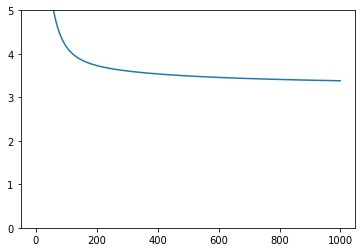

In [10]:
plt.plot(hist)
plt.ylim(0,5)

In [11]:
mupred = np.exp(np.matmul(Xdt, w))
np.sqrt(np.mean((mupred - y_test)**2)), NLL(y_test, Xdt,w)

(7.389176645536159, 2.8768358338221565)

## A) Poisson Regression using a NN build with Keras

Redo the analysis from above using Keras. You may (but don't have to) use tfp.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [13]:
# define model
inputs = tf.keras.Input(shape=(X_train.shape[1],))  
rate = tf.keras.layers.Dense(1, activation=tf.exp)(inputs)
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate)
 
model_p = tf.keras.Model(inputs=inputs, outputs=p_y)
 
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)
 
model_p.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [14]:
# train model
fit_model = model_p.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), verbose=2)

Epoch 1/1000
7/7 - 1s - loss: 11.3263 - val_loss: 9.7925
Epoch 2/1000
7/7 - 0s - loss: 10.2254 - val_loss: 8.8398
Epoch 3/1000
7/7 - 0s - loss: 9.1544 - val_loss: 7.9629
Epoch 4/1000
7/7 - 0s - loss: 8.3474 - val_loss: 7.1516
Epoch 5/1000
7/7 - 0s - loss: 7.5766 - val_loss: 6.4537
Epoch 6/1000
7/7 - 0s - loss: 6.7672 - val_loss: 5.9246
Epoch 7/1000
7/7 - 0s - loss: 6.3464 - val_loss: 5.4829
Epoch 8/1000
7/7 - 0s - loss: 5.8483 - val_loss: 5.1945
Epoch 9/1000
7/7 - 0s - loss: 5.5405 - val_loss: 4.9872
Epoch 10/1000
7/7 - 0s - loss: 5.3027 - val_loss: 4.8317
Epoch 11/1000
7/7 - 0s - loss: 5.0975 - val_loss: 4.7257
Epoch 12/1000
7/7 - 0s - loss: 4.9760 - val_loss: 4.6316
Epoch 13/1000
7/7 - 0s - loss: 4.8858 - val_loss: 4.5540
Epoch 14/1000
7/7 - 0s - loss: 4.7930 - val_loss: 4.4976
Epoch 15/1000
7/7 - 0s - loss: 4.7495 - val_loss: 4.4561
Epoch 16/1000
7/7 - 0s - loss: 4.6778 - val_loss: 4.4062
Epoch 17/1000
7/7 - 0s - loss: 4.6142 - val_loss: 4.3465
Epoch 18/1000
7/7 - 0s - loss: 4.5675 

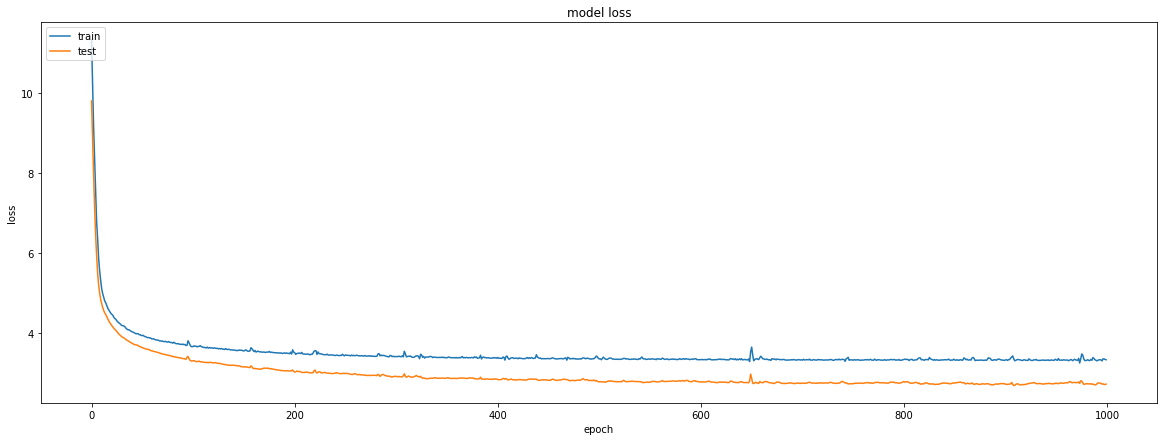

In [15]:
# plot results
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
axes.plot(fit_model.history['loss'])
axes.plot(fit_model.history['val_loss'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left')

Text(0.5, 0, 'predicted average of caught fish')

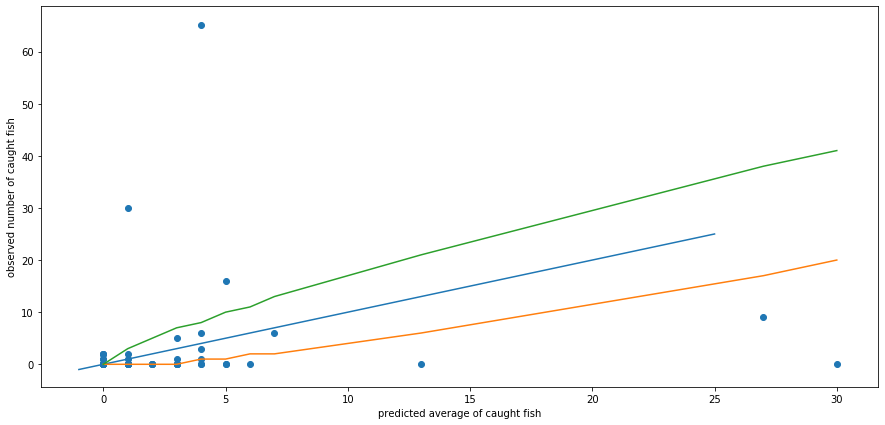

In [17]:
# evaluate the model
y_pred = model_p.predict(X_test)
y_pred = y_pred.flatten()
y_pred = np.sort(y_pred)

# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
x = np.linspace(-1, 25)
axes.plot(x, x)

# plot 2.5% percentile
percentiles = scipy.stats.poisson.ppf(0.025, y_pred)
axes.plot(y_pred, percentiles)

# plot 97.5% percentile
percentiles = scipy.stats.poisson.ppf(0.975, y_pred)
axes.plot(y_pred, percentiles)

axes.scatter(np.asarray(y_pred).flatten(), y_test)
axes.set_ylabel("observed number of caught fish")
axes.set_xlabel("predicted average of caught fish")

predicted fish: 4.0
real fish: 6.0


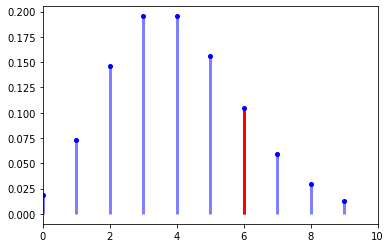

In [23]:
# plot the Poisson distribution for a given point
idx = 38

mu = y_pred[idx]

print("predicted fish:", y_pred[idx])
print("real fish:", y_test[idx])

x_values = x = np.arange(-10, 10)
y_values = scipy.stats.poisson(mu)

fig, ax = plt.subplots(1, 1)
ax.plot(x, scipy.stats.poisson.pmf(x, mu), 'bo', ms=4)
ax.vlines(x, 0, scipy.stats.poisson.pmf(x, mu), colors='b', lw=3, alpha=0.5)
ax.vlines(y_test[idx], 0, scipy.stats.poisson.pmf(y_test[idx], mu), colors='r', lw=3)
plt.xlim(0, 10)
plt.show()